In [1]:
# Connect to a STAC catalog and search for Sentinel-1 SAR data

from pystac_client import Client
import stackstac
import xarray as xr
import dask

# Connect to Microsoft Planetary Computer STAC API
stac_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
stac = Client.open(stac_url)

# Define search parameters for Sentinel-1 GRD data
search = stac.search(
    collections=["sentinel-1-grd"],
    bbox=[14.40, 61.0, 15.18, 61.27],  # Sweden area
    datetime="2025-12-20/2026-01-19",
    query={"sat:orbit_state": {"eq": "descending"}, "sar:instrument_mode": {"eq": "IW"}},
    limit=5  # Only fetch 5 items for testing
)

items = list(search.items())  # Using items() instead of deprecated get_items()
print(f"Found {len(items)} Sentinel-1 items.")

Found 10 Sentinel-1 items.


In [2]:
# Cell 3: Explore the first item's metadata
first_item = items[0]
print("Item ID:", first_item.id)
print("Date:", first_item.datetime)
print("\nAvailable assets:")
for asset_key, asset in first_item.assets.items():
    print(f"  - {asset_key}: {asset.title if hasattr(asset, 'title') else 'N/A'}")

Item ID: S1A_IW_GRDH_1SDV_20260118T051457_20260118T051522_062817_07E112
Date: 2026-01-18 05:15:10.082241+00:00

Available assets:
  - vh: VH: vertical transmit, horizontal receive
  - vv: VV: vertical transmit, vertical receive
  - thumbnail: Preview Image
  - safe-manifest: Manifest File
  - schema-noise-vh: VH Noise Schema
  - schema-noise-vv: VV Noise Schema
  - schema-product-vh: VH Product Schema
  - schema-product-vv: VV Product Schema
  - schema-calibration-vh: VH Calibration Schema
  - schema-calibration-vv: VV Calibration Schema
  - tilejson: TileJSON with default rendering
  - rendered_preview: Rendered preview


In [3]:
# Cell 4: Load data using odc-stac with explicit CRS
import planetary_computer
from odc.stac import load

# Sign the items for accessing Microsoft Planetary Computer data
signed_items = [planetary_computer.sign(item) for item in items]

# Load data with odc-stac - explicitly specify CRS for Sweden area
# Sweden is in UTM zone 33N (EPSG:32633)
stack = load(
    signed_items,
    bands=["vh", "vv"],  # Sentinel-1 polarizations
    chunks={"x": 512, "y": 512},  # Chunk size for processing
    crs="EPSG:32633",  # UTM zone 33N for Sweden (NOT 4326!)
    resolution=10,  # 10m resolution in meters (valid for UTM, not for EPSG:4326)
    bbox=[14.40, 61.0, 15.18, 61.27], # Sweden area in lat/lon (will be reprojected)
)

print("Data stack shape:", stack)
print("\nData type:", type(stack.vv.data))  # Should show dask array

Data stack shape: <xarray.Dataset> Size: 1GB
Dimensions:      (y: 3021, x: 4220, time: 10)
Coordinates:
  * y            (y) float64 24kB 6.793e+06 6.793e+06 ... 6.763e+06 6.763e+06
  * x            (x) float64 34kB 4.675e+05 4.676e+05 ... 5.097e+05 5.097e+05
  * time         (time) datetime64[ns] 80B 2025-12-23T05:31:34.040051 ... 202...
    spatial_ref  int32 4B 32633
Data variables:
    vh           (time, y, x) float32 510MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    vv           (time, y, x) float32 510MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

Data type: <class 'dask.array.core.Array'>


In [5]:
# Cell 5: Inspect the xarray dataset
print(stack)

<xarray.Dataset> Size: 1GB
Dimensions:      (y: 3021, x: 4220, time: 10)
Coordinates:
  * y            (y) float64 24kB 6.793e+06 6.793e+06 ... 6.763e+06 6.763e+06
  * x            (x) float64 34kB 4.675e+05 4.676e+05 ... 5.097e+05 5.097e+05
  * time         (time) datetime64[ns] 80B 2025-12-23T05:31:34.040051 ... 202...
    spatial_ref  int32 4B 32633
Data variables:
    vh           (time, y, x) float32 510MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    vv           (time, y, x) float32 510MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>


In [10]:
# Cell 6: Scale for larger area - Example with expanded search
# This demonstrates how to scale up without loading everything into memory

large_search = stac.search(
    collections=["sentinel-1-grd"],
    bbox=[14.40, 61.0, 15.18, 61.27],  # Berlin area
    datetime="2026-01-10/2026-01-19",  # Full year
    query={
        "sat:orbit_state": {"eq": "descending"}, 
        "sar:instrument_mode": {"eq": "IW"}
    },
    limit=100  # Larger dataset
)

large_items = list(large_search.items())
print(f"Found {len(large_items)} items for the specified date range")

# Only sign and load if you want to process - otherwise just metadata
# signed_large_items = [planetary_computer.sign(item) for item in large_items[:20]]

Found 4 items for the specified date range


In [11]:
# Download all images from large_search
import rioxarray
import os
from shapely.geometry import box
import shapely

if len(large_items) > 0:
    print(f"Processing {len(large_items)} images from large_search...")
    # Filter items to only include those intersecting the bounding box

    # Define the bounding box as a polygon (lon/lat)
    bbox_polygon = box(14.40, 61.0, 15.18, 61.27)

    # Filter items by spatial intersection
    filtered_items = []
    for item in large_items:
        item_geom = shapely.geometry.shape(item.geometry)
        if item_geom.intersects(bbox_polygon):
            filtered_items.append(item)

    print(f"Filtered to {len(filtered_items)} items intersecting the bounding box")
    large_items = filtered_items  # Update large_items to only include filtered items
    # Create output directory
    output_dir = "sentinel1_downloads"
    os.makedirs(output_dir, exist_ok=True)
    
    # Sign items for access
    signed_large_items = [planetary_computer.sign(item) for item in large_items]
    
    # Load all data at once with odc-stac
    # Note: bbox parameter is removed - odc-stac will use the footprint from the items
    large_stack = load(
        signed_large_items,
        bands=["vh", "vv"],
        chunks={"x": 512, "y": 512},
        crs="EPSG:32633",  # UTM zone 33N for Sweden
        resolution=10,
    )
    
    print(f"Loaded stack with {len(large_stack.time)} timesteps")
    print(f"Stack shape: {large_stack.vv.shape}")
    
    # Save each timestep as a separate GeoTIFF
    for i, time_val in enumerate(large_stack.time.values):
        # Extract single timestep for VV polarization
        img_vv = large_stack.vv.isel(time=i)
        img_vh = large_stack.vh.isel(time=i)
        
        # Compute (download) the data
        img_vv_computed = img_vv.compute()
        img_vh_computed = img_vh.compute()
        
        # Add CRS
        img_vv_computed = img_vv_computed.rio.write_crs("EPSG:32633")
        img_vh_computed = img_vh_computed.rio.write_crs("EPSG:32633")
        
        # Create filename with timestamp
        timestamp = str(time_val)[:19].replace(':', '-')
        filename_vv = f"{output_dir}/S1_VV_{timestamp}.tif"
        filename_vh = f"{output_dir}/S1_VH_{timestamp}.tif"
        
        # Save as GeoTIFF
        img_vv_computed.rio.to_raster(filename_vv, compress='lzw')
        img_vh_computed.rio.to_raster(filename_vh, compress='lzw')
        
        print(f"✓ [{i+1}/{len(large_stack.time)}] Saved: {timestamp}")
    
    print(f"\nAll images saved to: {output_dir}/")
    print(f"Total files: {len(large_stack.time) * 2} (VV + VH polarizations)")
else:
    print("No images found in large_search")

Processing 4 images from large_search...
Filtered to 4 items intersecting the bounding box
Loaded stack with 4 timesteps
Stack shape: (4, 35202, 52586)


Aborting load due to failure while reading: https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2026/1/10/IW/DV/S1C_IW_GRDH_1SDV_20260110T053005_20260110T053030_005837_00BAFE_21AB/measurement/iw-vh.tiff?st=2026-01-18T20%3A31%3A11Z&se=2026-01-19T21%3A16%3A11Z&sp=rl&sv=2025-07-05&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2026-01-19T20%3A26%3A47Z&ske=2026-01-26T20%3A26%3A47Z&sks=b&skv=2025-07-05&sig=IufMR8AMnvDdNcdnnA695/GZ19OYceI8FqP7GCAZFG8%3D:1


WarpOperationError: Chunk and warp failed

In [33]:
# Cell 7: Implement log-ratio change detection
import numpy as np

# Select VV polarization for change detection (odc-stac returns vv as a variable)
vv_data = stack.vv

# Sort by time to ensure chronological order
vv_data = vv_data.sortby('time')

print(f"VV data shape: {vv_data.shape}")
print(f"Time range: {vv_data.time.min().values} to {vv_data.time.max().values}")

# Select first and last images for change detection
if len(vv_data.time) >= 2:
    image_before = vv_data.isel(time=0)
    image_after = vv_data.isel(time=-1)
    
    # Log-ratio change detection (in dB)
    # log_ratio = 10 * log10(after / before)
    log_ratio = 10 * np.log10((image_after + 1e-10) / (image_before + 1e-10))
    
    print("\nChange detection computed (lazy - not yet executed)")
    print(f"Log ratio shape: {log_ratio.shape}")
else:
    print("Need at least 2 images for change detection")

VV data shape: (38, 22439, 11155)
Time range: 2025-12-22T05:38:33.792577000 to 2026-01-18T05:15:35.082754000

Change detection computed (lazy - not yet executed)
Log ratio shape: (22439, 11155)


In [29]:
!pip install rioxarray

In [34]:
# Download (compute and save) image_before and image_after as GeoTIFF
import rioxarray

if len(vv_data.time) >= 2:
    # Compute the images (download from lazy dask arrays)
    print("Computing and saving images...")
    
    # Add CRS information
    image_before_computed = image_before.compute()
    image_after_computed = image_after.compute()
    
    # Write CRS metadata
    image_before_computed = image_before_computed.rio.write_crs("EPSG:32633")
    image_after_computed = image_after_computed.rio.write_crs("EPSG:32633")
    
    # Save as GeoTIFF files
    image_before_computed.rio.to_raster(
        "image_before_vv.tif", 
        compress='lzw'
    )
    print(f"✓ Saved: image_before_vv.tif ({str(image_before.time.values)[:10]})")
    
    image_after_computed.rio.to_raster(
        "image_after_vv.tif", 
        compress='lzw'
    )
    print(f"✓ Saved: image_after_vv.tif ({str(image_after.time.values)[:10]})")
    
    print(f"\nImage dimensions: {image_before_computed.shape}")
    print(f"CRS: EPSG:32633 (UTM Zone 33N)")
else:
    print("Need at least 2 images")

Computing and saving images...
✓ Saved: image_before_vv.tif (2025-12-22)
✓ Saved: image_after_vv.tif (2026-01-18)

Image dimensions: (22439, 11155)
CRS: EPSG:32633 (UTM Zone 33N)


In [35]:
# Cell 8: Compute results in chunks using Dask
# This will process the data in chunks without loading everything into memory

if len(vv_data.time) >= 2:
    # Compute only a subset first to test
    log_ratio_computed = log_ratio.compute()  # This triggers actual computation
    
    # Check for invalid values
    print(f"Computed change detection map")
    print(f"Data contains NaN: {np.isnan(log_ratio_computed).any().item()}")
    print(f"Data contains Inf: {np.isinf(log_ratio_computed).any().item()}")
    
    # Use nanmin, nanmax, nanmean to ignore NaN values in statistics
    print(f"Min change: {float(np.nanmin(log_ratio_computed)):.2f} dB")
    print(f"Max change: {float(np.nanmax(log_ratio_computed)):.2f} dB")
    print(f"Mean change: {float(np.nanmean(log_ratio_computed)):.2f} dB")
    print(f"Percentage of valid pixels: {(~np.isnan(log_ratio_computed)).sum() / log_ratio_computed.size * 100:.1f}%")
    
    # Replace NaN/Inf with 0 for visualization
    log_ratio_computed = np.nan_to_num(log_ratio_computed, nan=0.0, posinf=0.0, neginf=0.0)


Computed change detection map
Data contains NaN: True
Data contains Inf: False
Min change: nan dB
Max change: nan dB
Mean change: nan dB
Percentage of valid pixels: 0.0%


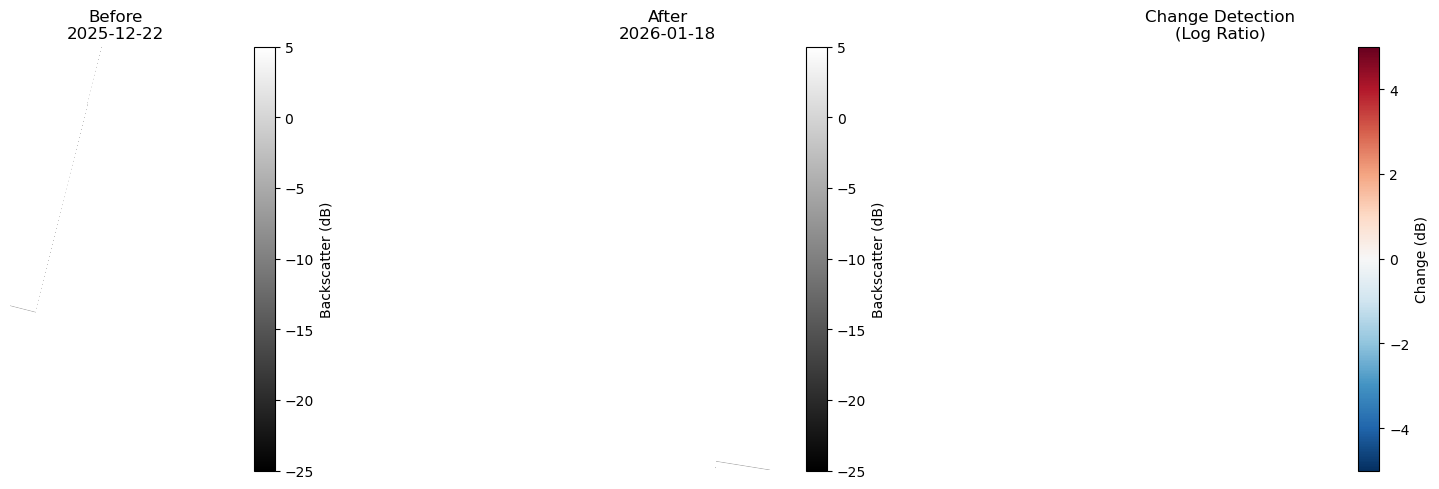

In [15]:
# Cell 9: Visualize results
import matplotlib.pyplot as plt

if len(vv_data.time) >= 2:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Before image (in dB)
    im1 = axes[0].imshow(10 * np.log10(image_before.compute() + 1e-10), 
                         cmap='gray', vmin=-25, vmax=5)
    axes[0].set_title(f'Before\n{str(image_before.time.values)[:10]}')
    axes[0].axis('off')
    plt.colorbar(im1, ax=axes[0], label='Backscatter (dB)')
    
    # After image (in dB)
    im2 = axes[1].imshow(10 * np.log10(image_after.compute() + 1e-10), 
                         cmap='gray', vmin=-25, vmax=5)
    axes[1].set_title(f'After\n{str(image_after.time.values)[:10]}')
    axes[1].axis('off')
    plt.colorbar(im2, ax=axes[1], label='Backscatter (dB)')
    
    # Change detection
    im3 = axes[2].imshow(log_ratio_computed, cmap='RdBu_r', vmin=-5, vmax=5)
    axes[2].set_title('Change Detection\n(Log Ratio)')
    axes[2].axis('off')
    plt.colorbar(im3, ax=axes[2], label='Change (dB)')
    
    plt.tight_layout()
    plt.show()

In [16]:
# Cell 10: Advanced - Process larger dataset with Dask distributed
# This shows how to scale to even larger datasets

from dask.diagnostics import ProgressBar

# Example: compute statistics across all time steps without loading into memory
if len(vv_data.time) > 0:
    with ProgressBar():
        # Compute mean backscatter over time (processes in chunks)
        temporal_mean = vv_data.mean(dim='time').compute()
        temporal_std = vv_data.std(dim='time').compute()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    im1 = axes[0].imshow(10 * np.log10(temporal_mean + 1e-10), cmap='gray')
    axes[0].set_title('Temporal Mean (dB)')
    axes[0].axis('off')
    plt.colorbar(im1, ax=axes[0])
    
    im2 = axes[1].imshow(10 * np.log10(temporal_std + 1e-10), cmap='viridis')
    axes[1].set_title('Temporal Std Dev (dB)')
    axes[1].axis('off')
    plt.colorbar(im2, ax=axes[1])
    
    plt.tight_layout()
    plt.show()

[#######                                 ] | 19% Completed | 25m 58ss


KeyboardInterrupt: 

In [ ]:
# Cell 10.5: Save processed results as GeoTIFF
import rioxarray  # Extends xarray with raster I/O capabilities

# Save change detection result
if len(vv_data.time) >= 2:
    # Add spatial reference info if not already present
    log_ratio_computed = log_ratio_computed.rio.write_crs("EPSG:32633")
    
    # Save as GeoTIFF
    log_ratio_computed.rio.to_raster("change_detection_log_ratio.tif", compress='lzw')
    print("Saved change detection to: change_detection_log_ratio.tif")

# Save temporal statistics
if len(vv_data.time) > 0:
    temporal_mean = temporal_mean.rio.write_crs("EPSG:32633")
    temporal_std = temporal_std.rio.write_crs("EPSG:32633")
    
    temporal_mean.rio.to_raster("temporal_mean_vv.tif", compress='lzw')
    temporal_std.rio.to_raster("temporal_std_vv.tif", compress='lzw')
    
    print("Saved temporal mean to: temporal_mean_vv.tif")
    print("Saved temporal std to: temporal_std_vv.tif")

# Optional: Save individual timesteps
# for i, time_step in enumerate(vv_data.time):
#     img = vv_data.isel(time=i).rio.write_crs("EPSG:32633")
#     img.rio.to_raster(f"vv_image_{i}_{str(time_step.values)[:10]}.tif", compress='lzw')


In [ ]:
# Cell 11: Optional - Set up Dask distributed client for parallel processing
from dask.distributed import Client, LocalCluster

# Uncomment to use distributed processing
# cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit='2GB')
# client = Client(cluster)
# print(client)
# print("Dashboard link:", client.dashboard_link)

# After setting up client, all .compute() calls will use distributed processing
# Don't forget to close: client.close() and cluster.close()